In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import math
import pandas as pd
import xgboost
import lightgbm
#import catboost не устанавливается

from matplotlib.colors import ListedColormap
from scipy.stats import pearsonr
from itertools import combinations
from sklearn.base import BaseEstimator
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier,
                              VotingClassifier)
from sklearn.tree import (DecisionTreeRegressor,
                          DecisionTreeClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

In [3]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Bias-variance trade-off

**2 балла**

Продемонстрируйте bias-variance trade-off для `DecisionTreeRegressor` при изменении глубины дерева. Постройте регрессионную модель функции от одной независимой переменной, представленной в ячейке ниже, используя функцию `plot_regression_predictions` (можете ее как-то поменять, если захочется). Попробуйте разные значения глубины деревьев, при каком значении, на ваш взгляд, модель оптимальна, при каком variance становится слишком большим?

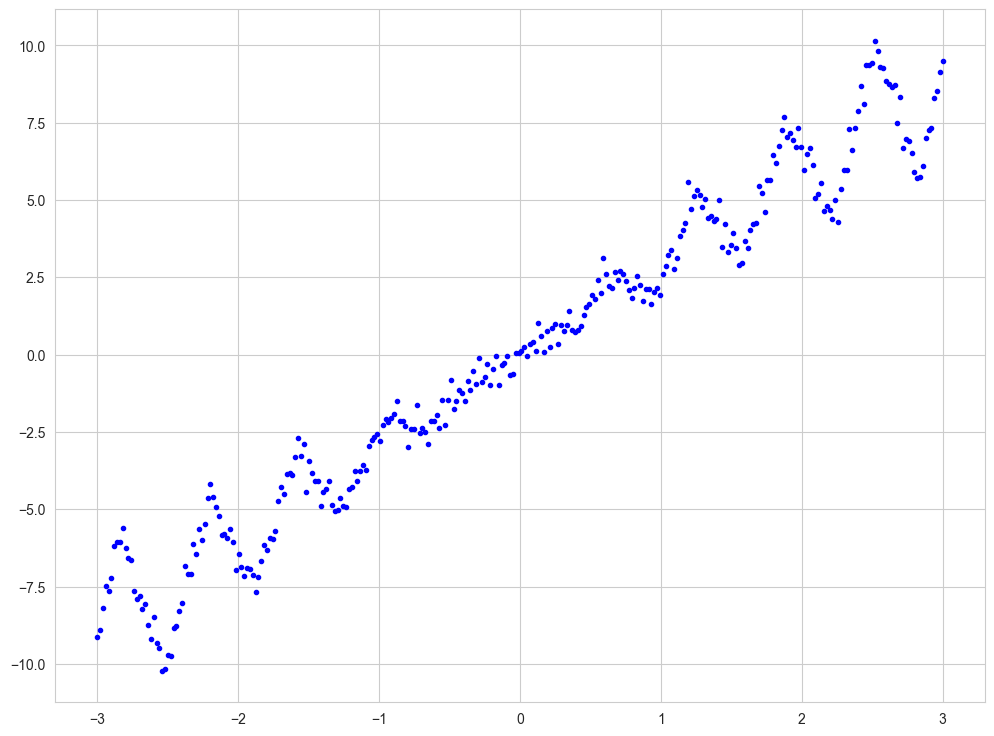

In [14]:
# Сгенерируем какую-нибудь необычную зависимость и научимся ее предсказывать
np.random.seed(42)
m = 300
X = np.linspace(-3, 3, m).reshape(-1, 1)
y = (3 + 2/np.pi * np.arcsin(np.cos(10 * X))) * X
y = y + np.random.randn(m, 1) / 3
plt.plot(X.reshape(-1), y.reshape(-1), "b.");

In [29]:
# Функция для отрисовки предсказаний деревьев решений в случае регрессии
def plot_regression_predictions(tree_reg, X, y, axes=[-3, 3, -10, 10], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.scatter(X, y, c='grey', alpha=0.7, s=3)
    plt.plot(x1, y_pred, linewidth=2, label=r"$\hat{y}$")

Изобразите, как меняются предсказания дерева при увеличении максимальной глубины (можно взять что-то в диапазоне от 1 до 15):

In [2]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

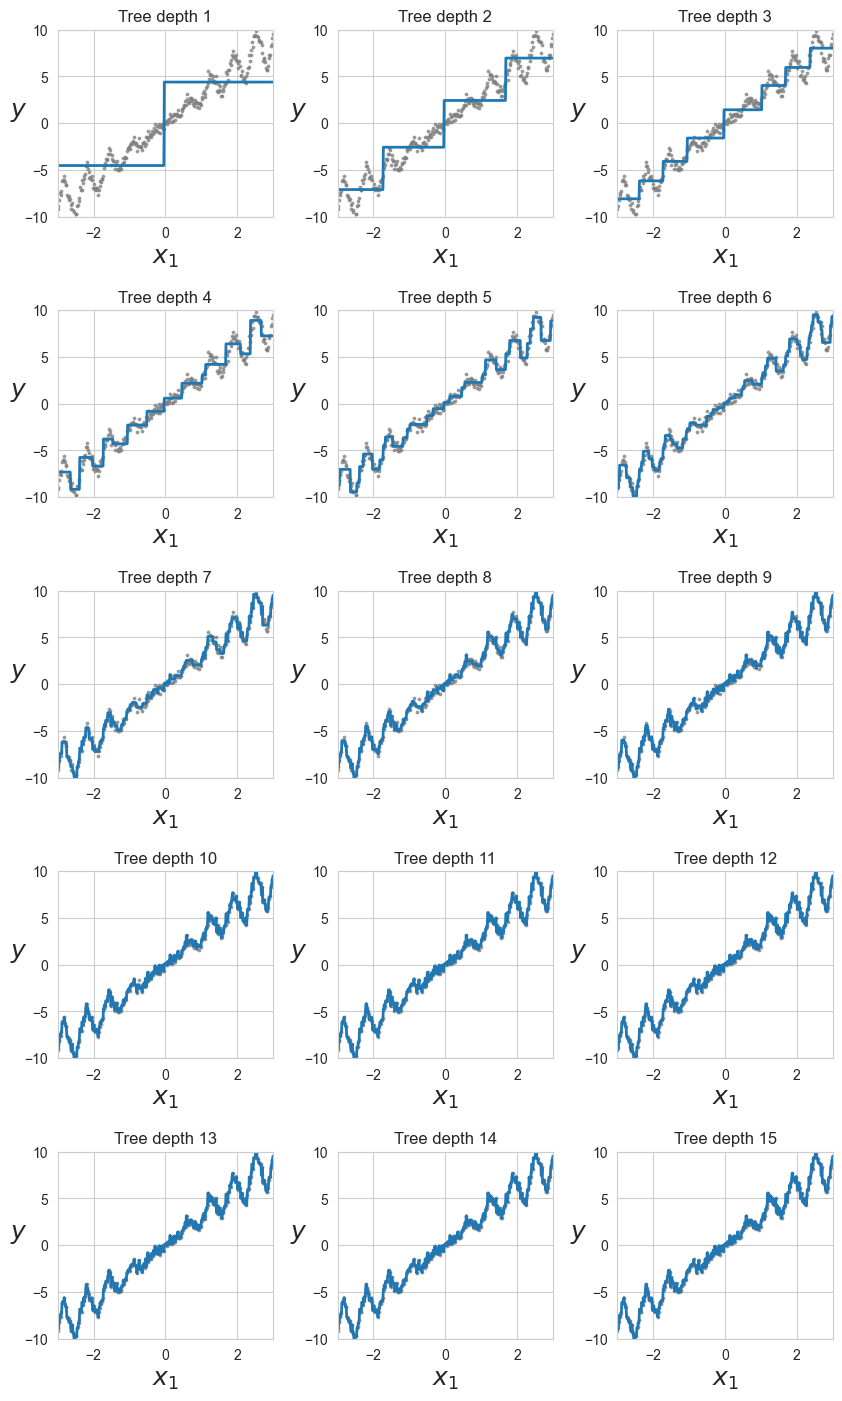

In [56]:
plt.rcParams["figure.figsize"] = 10, 17
for depth in range(1, 16):
    plt.subplot(5, 3, depth)
    tree = DecisionTreeRegressor(max_depth=depth)
    tree.fit(X, y)
    plot_regression_predictions(tree, X, y)
    plt.title(f'Tree depth {depth}')
plt.subplots_adjust(wspace=0.3, hspace=0.5)

С увеличение глубины уменьшается bias модели, но, кажется, после глубины 6 и дальше, дерево пытается "поймать" вообще все данные, начинает учится на шуме в том числе, то есть увеличивается variance

### Задание 2. Random forest

Теперь давайте немного подготовимся к тому, чтобы реализовать свой собственный случайный лес, а потом реализуем его.

#### Задание 2. 1. Простое ансамблирование

**1 балла**

Представим, что у нас есть 101 классификатор. Каждый может с вероятностью `p` (равной для всех моделей) правильно предсказать класс объекта. Будем делать предсказания по большинству голосов (majority vote). Постройте зависимость вероятности правильно классифицировать объект от значения `p`. Вам может быть полезная следующая формула:

$$ \large \mu = \sum_ {i = 51} ^ {101} C_{101} ^ ip ^ i (1-p) ^ {101-i} $$

In [114]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
import math
probabilities = np.linspace(0, 1, num=101)
mu = 0
for i in range(51, 102):
    combinantions = math.factorial(101)/(math.factorial(i) * math.factorial(101 - i))
    mu += combinantions * np.power(probabilities, i) * np.power((1 - probabilities), (101 - i))

column_names = ['prob', 'mu']
prob_mu = pd.DataFrame(data = np.column_stack((probabilities, mu)),    
                  columns = column_names) 


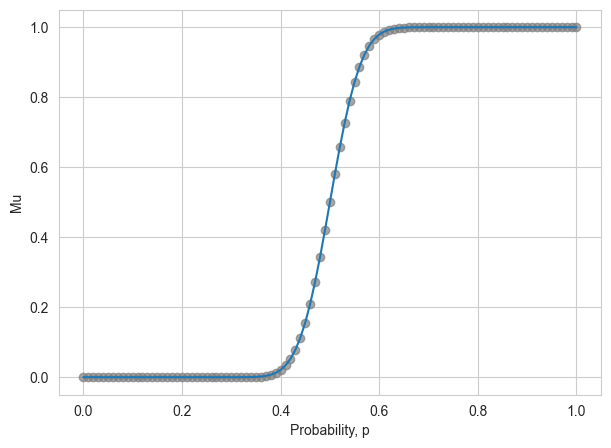

In [115]:
plt.rcParams["figure.figsize"] = 7, 5
plt.plot(prob_mu['prob'], prob_mu['mu'])
plt.scatter(prob_mu['prob'], prob_mu['mu'], c='grey', alpha=0.7)
plt.xlabel('Probability, p')
plt.ylabel('Mu')
None

А теперь давайте посмотрим на другую ситуацию. У нас есть фиксированная вероятность того, что модель правильно классифицирует объект `p = 0.65`. Постройте зависимость вероятности правильно классифицировать объект от числа моделей в ансамбле.

In [ ]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

не знаю, как будто че то не получается. не стала оставлять(

Опишите ваши наблюдения:

* с увеличением вероятности предсказать класс каждого отдельного классификатора увеличивается mu всего ансамбля. mu свыше 0.98 достигается уже при значении вероятности 0.6. Значит для хорошего перформанса ансамбля не нужна очень уж высокая вероятность правильно прежсказать отдельного классификатора. Что логично, наверно. Ниже 0.5 делают предсказания ансамбля сильно хуже
* ...

#### Задание 2. 2. Реализация простого RF

**4 балла**

Реализуйте свой собственный класс `RandomForestClassifierCustom`, используя в качестве базовой модели `DecisionTreeClassifier` из `sklearn`.

Небольшое описание:
- Используйте приведенный ниже код
- В методе `fit` в цикле (`i` от 0 до `n_estimators-1`):
    * Зафиксируйте генератор случайных чисел следующим образом np.random.seed(`random_state + i`). Идея в том, что на каждой итерации у нас будет новое значение для генератора случайных чисел, что добавит побольше "случайности", но в то же время мы сможем иметь воспроизводимые результаты
    * После чего выберите `max_features` признаков **без возвращения/without replacement**, сохраните список выбранных признаков (их индексов) в `self.feat_ids_by_tree`
    * Также создайте псевдовыборку при помощи бутстрэпа (выбор **с возвращением/with replacement**) из тренировочных данных. Может помочь функция `np.random.choice` и ее аргумент `replace`
    * Обучите дерево решений с параметрами, заданными в конструкторе класса `max_depth`, `max_features` и `random_state` на полученной псевдовыборке.
- Метод `fit` должен возвращать текущий экземпляр класса `RandomForestClassifierCustom`, то есть `self` (все по-взрослому, как в `sklearn`)
- В методе `predict_proba` мы должны пройти циклом по всем деревьям. Для каждого предсказания, нам нужно будет брать только те признаки, на которых училось изначальное дерево, поэтому мы и сохраняли эту информацию в артрибуте `self.feat_ids_by_tree`. Этот метод должен возвращать предсказанные вероятности (можно делать двумя способами: для каждого дерева предсказывать значение при помощи метода `predict_proba` и потом усреднять эти вероятности, или к примеру пользоваться методом `predict` и также считать среднее.

In [14]:
class RandomForestClassifierCustom(BaseEstimator):
    def __init__(
        self, n_estimators=10, max_depth=None, max_features=None, random_state=SEED
    ):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state

        self.trees = []
        self.feat_ids_by_tree = []

    def fit(self, X, y):
        self.classes_ = sorted(np.unique(y))
        for tree in range(self.n_estimators):
            np.random.seed(seed = self.random_state + tree)
            feat = np.random.choice(X.shape[1], size=self.max_features)
            self.feat_ids_by_tree.append(feat)
            idx_to_stay = np.random.choice(X.shape[0], size=X.shape[0], replace=True) #random sample indicies
            sample_X = X[np.ix_(idx_to_stay, feat)] # features values
            sample_y = y[idx_to_stay] 
            des_tree = DecisionTreeClassifier(max_depth=self.max_depth, max_features=self.max_features, random_state=SEED)
            des_tree.fit(sample_X, sample_y)
            self.trees.append(des_tree)
        return self
        ## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

    def predict_proba(self, X):
        predictions = []
        for tree, n in zip(self.trees, self.feat_ids_by_tree):
            pred_tree = tree.predict_proba(X[:, n])
            predictions.append(pred_tree)
        predictions = np.array(predictions)
        return np.mean(predictions, axis=0)
        ## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
    
    def predict(self, X):
        probas = self.predict_proba(X)
        predictions = np.argmax(probas, axis=1)
        
        return predictions

Протестируем нашу реализацию на искусственных данных. Визуализируйте разделяющую границу, которую рисует ваша модель при помощи функции `plot_decision_boundary` (см. примеры в лекции).

In [15]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#ffdab9","#9898ff", "#4B0082"])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(["#ffdab9", "#4c4c7f", "#4B0082"])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

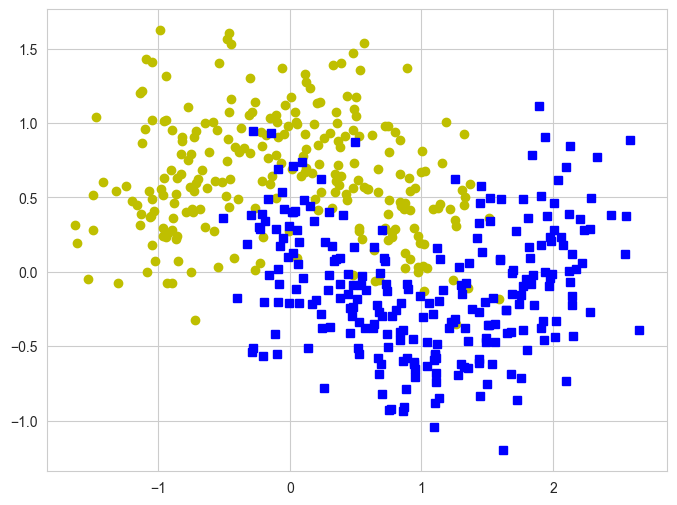

In [16]:
X, y = datasets.make_moons(n_samples=500, noise=0.30, random_state=SEED)

plt.figure(figsize=(8, 6))
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.show()

Попробуем варьировать, например, глубину дерева, просто для визуализиции


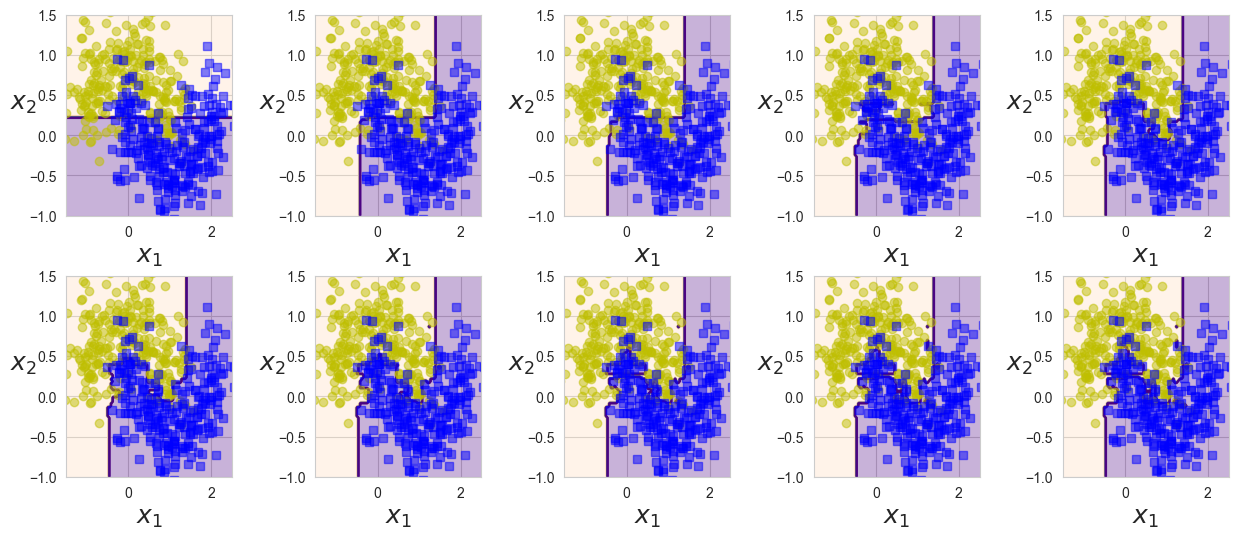

In [17]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
plt.rcParams["figure.figsize"] = 15, 6
for depth in range(1, 11):
    plt.subplot(2, 5, depth)
    rfc = RandomForestClassifierCustom(n_estimators=20 ,max_depth=depth, max_features=6)
    rfc.fit(X,y)
    plot_decision_boundary(rfc, X, y)
plt.subplots_adjust(wspace=0.5, hspace=0.3)

Больше глубины 6-7 уже не очень, ловит шум. Попробуем подобрать гиперпараметры случайного леса, используя `GridSearchCV` и `RandomizerSearchCV`

Подберите наилучшие гиперпараметры, при которых разделяющая граница будет, на ваш взгляд, оптимальной с точки зрения bias-variance. Можно также подключить какие-то метрики для выбора лучшей модели.

In [351]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

rfc = RandomForestClassifierCustom()

param = {'n_estimators': range(1, 20),
         'max_depth': range(1, 20),
         'max_features': range(1,20)
         }

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=2)

grid_search = GridSearchCV(rfc, param, cv=5, scoring='precision')
grid_search.fit(X_train, y_train)
print(grid_search.best_score_)
grid_search.best_params_

0.9489446963862982


{'max_depth': 10, 'max_features': 10, 'n_estimators': 2}

In [22]:

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
param = {'n_estimators': range(1, 20),
         'max_depth': range(1, 20),
         'max_features': range(1,20)
         }
rfc_random = RandomForestClassifierCustom()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=32)
random_search = RandomizedSearchCV(rfc_random, param, cv=5, scoring='f1')
random_search.fit(X_train, y_train)
print(random_search.best_score_)
par = random_search.best_params_
print(par)

0.8920506557927628
{'n_estimators': 11, 'max_features': 5, 'max_depth': 6}


Не совсем понимаю, почему такие разные результаты выходял. Возьму результаты рандома, потому что он прогоняется быстрее.

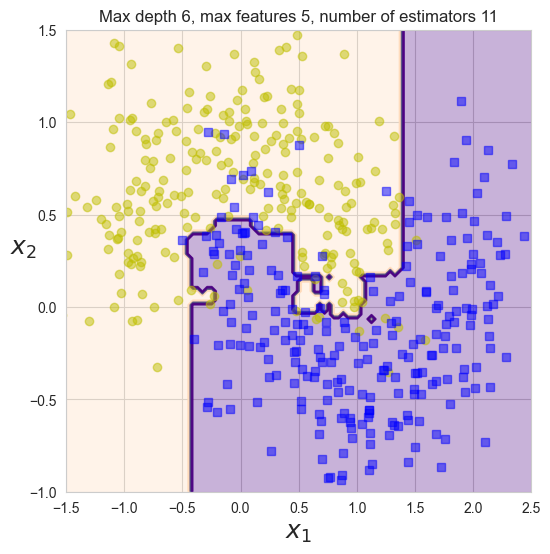

In [23]:
best_depth = par['max_depth']
best_feat_num = par['max_features']
best_estim_num = par['n_estimators']

plt.rcParams["figure.figsize"] = 6, 6
rfc_best = RandomForestClassifierCustom(n_estimators=best_estim_num ,max_depth=best_depth, max_features=best_feat_num)
rfc_best.fit(X,y)
plot_decision_boundary(rfc_best, X, y)
plt.title(f'Max depth {best_depth}, max features {best_feat_num}, number of estimators {best_estim_num}')
None

#### Задание 2. 3. Корреляция базовых моделей

**3 балла**

Как мы выянили на лекции, для того, чтобы bagging работал хорошо, предсказания наших моделей не должны сильно коррелировать. Для этого в случайном лесе применяются различные подходы, в том числе и RSM. Давайте посмотрим, как влияет параметр `max_features` на корреляцию базовых моделей в случайном лесу из `sklearn`. В качестве примера будем использовать датасет `breast_cancer`. Для расчета корреляций используйте приведенную ниже функцию `base_model_pair_correlation`. Для каждой модели у вас будет получаться набор значений (попарные корреляции всех деревьев), дальше можно изобразить их в виде боксплотов, как мы на лекции рисовали распределение метрик.

In [24]:
# Функция для расчета попарных корреляций базовых моделей в случайном лесу
def base_model_pair_correlation(ensemble, X):
    corrs = []
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        ypred_t2 = est2.predict_proba(Xj_test)[:, 1]

        corrs.append(pearsonr(ypred_t1, ypred_t2)[0])
    return np.array(corrs)

In [25]:
# Загрузим данные
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [26]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
compare_dataframe = pd.DataFrame()
num_features = np.arange(1, 21)
for num in num_features:
    mdl = RandomForestClassifier(max_features=num)
    mdl.fit(X_train, y_train)
    array = base_model_pair_correlation(mdl, X_train)
    compare_dataframe = pd.concat([compare_dataframe, pd.DataFrame(array)], axis=1)


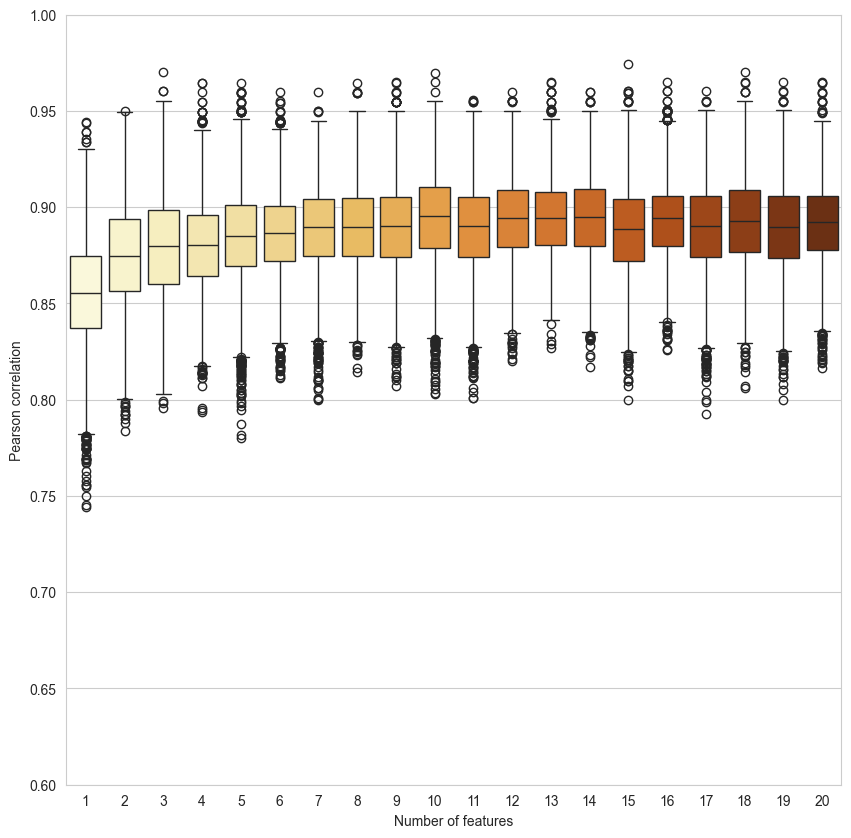

In [27]:
compare_dataframe.columns = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
plt.rcParams["figure.figsize"] = 10, 10
sns.boxplot(compare_dataframe, palette='YlOrBr')
plt.ylabel('Pearson correlation')
plt.xlabel('Number of features')
plt.ylim(0.6,1)
None

Теперь давайте посмотрим, как на это влияет параметр `max_depth`:

In [28]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
compare_dataframe = pd.DataFrame()
depth = np.arange(1, 21)
for num in num_features:
    mdl = RandomForestClassifier(max_depth=num)
    mdl.fit(X_train, y_train)
    array = base_model_pair_correlation(mdl, X_train)
    compare_dataframe = pd.concat([compare_dataframe, pd.DataFrame(array)], axis=1)

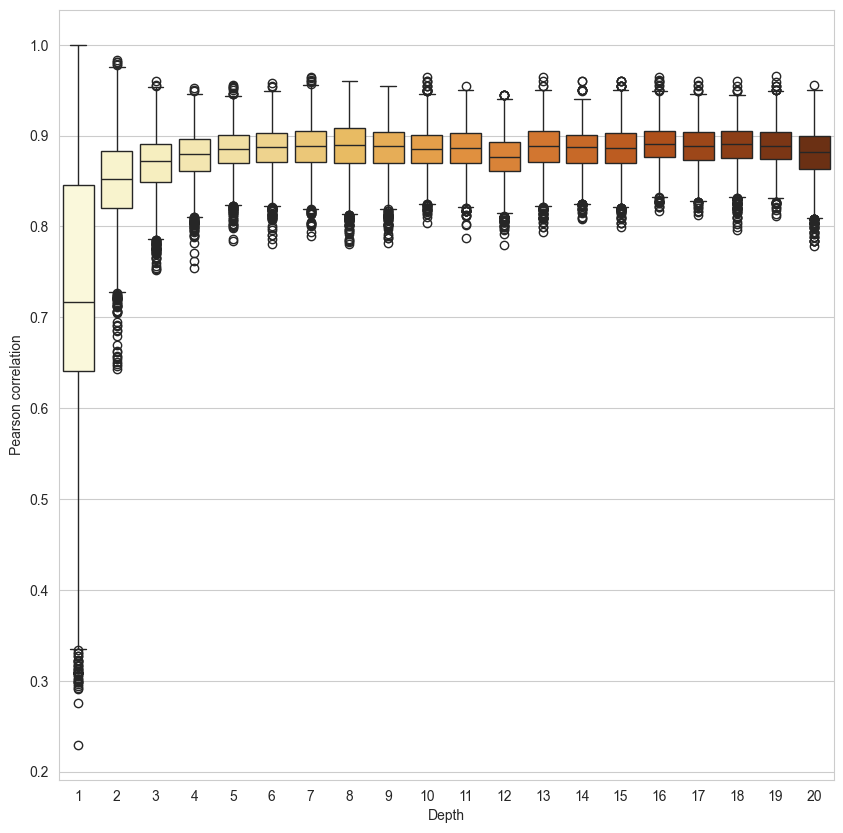

In [29]:
compare_dataframe.columns = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
plt.rcParams["figure.figsize"] = 10, 10
sns.boxplot(compare_dataframe, palette='YlOrBr')
plt.ylabel('Pearson correlation')
plt.xlabel('Depth')
#plt.ylim(0.5,1)
None

Опишите ваши наблюдения:

* С увеличением числа фичей возрастает корреляция, но выше 0.9 в медиане не достигает. Усы правда до 1 доходят. Наверно до 10-15 можно варьровать число фичей, без особо увеличения корреляции.
* Глубина дерева сказывается похожим образом, если глубина = 1, то разброс очень широкий, очень нестабильный. 

### Задание 3. Строим большой ансамбль

**4 балла + 3 дополнительных за скор выше 0.87**

В данной задаче вам нужно диагностировать сердечное заболевание у людей по медицинским показателям.

In [111]:
!gdown  --id 1VFbDK-Ad-hpf0_GGCBzn4thdn9mkQ-Y- -O heart.csv -q
heart_dataset = pd.read_csv("../data/heart.csv")

/Users/anastasiastompel/mambaforge/envs/new_mac/lib/python3.8/site-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(


In [112]:
X = heart_dataset.drop("target", axis=1)
y = heart_dataset["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
X_train.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
178,43,1,0,120,177,0,0,120,1,2.5,1,0,3
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3
201,60,1,0,125,258,0,0,141,1,2.8,1,1,3
246,56,0,0,134,409,0,0,150,1,1.9,1,2,3
153,66,0,2,146,278,0,0,152,0,0.0,1,1,2


Обучите разнообразные классификаторы, приведенные ниже, а также ансамбль `VotingClassifier` из `sklearn.ensemble`, объединяющий эти классификаторы с помощью жесткого или мякого голосования (параметр `voting =` `'hard'` или `'soft'` соответственно). Оцените качество моделей с помощью кросс-валидации на тренировочном наборе, используя функцию `cross_val_score` и метрику `f1`. Часть моделей отсюда мы не проходили, о них можно почитать дополнительно, но в принципе для задания не очень важно знать принципы их работы (но, если есть время, то почитайте, там интересно).

In [34]:
dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=50, random_state=SEED)
etc = ExtraTreesClassifier(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
#cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED, force_col_wise=True, verbose= -100)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED, force_col_wise=True, verbose= -100)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()

base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               #("CAT", cat), 
               ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

Здесь могут возникать различные предупреждения при обучении бустингов, не волнуйтесь, все нормально, просто они обычно очень разговорчивые)

In [35]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
voting_hard = VotingClassifier(estimators = base_models, voting = 'hard')
voting_soft = VotingClassifier(estimators = base_models, voting = 'soft')

## END YOUR CODE HERE ##

for model in [dt, rf, etc, knn, svc_lin, svc_rbf, xgb, lgbm, xgb_rf, lgbm_rf, lr, nb, voting_hard, voting_soft]: 
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    print(f"{model.__class__.__name__}: {scores.mean()}")

DecisionTreeClassifier: 0.797997226792219
RandomForestClassifier: 0.8328751280279528
ExtraTreesClassifier: 0.828174603174603
KNeighborsClassifier: 0.6493313763861709
SVC: 0.8403098469098905
SVC: 0.6973119072190279
XGBClassifier: 0.8134522115571786
LGBMClassifier: 0.8170106316447779
XGBRFClassifier: 0.8462669018224575
LGBMClassifier: 0.8132478632478634
LogisticRegression: 0.8500073681108163
GaussianNB: 0.8140676625250128
VotingClassifier: 0.85143994782549
VotingClassifier: 0.8503633581946834


Вы можете заметить, что ансамбль показывает хорошее, но не лучшее качество предсказания, попробуем его улучшить. Как вы знаете, ансамбли работают лучше, когда модели, входящие в них не скоррелированы друг с другом. Определите корреляцию предсказаний базовых моделей в ансамбле на тестовом наборе данных, и удалите из ансамбля те модели, чьи предсказания будут сильнее коррелировать с остальными. Воспользуйтесь функцией `base_model_pair_correlation_for_voting_clf`. **Спойлер**: далеко не факт, что если вы удалите две модели с корреляцией 0.95, то все станет сильно лучше, здесь все будет немного сложнее. Чтобы добиться максимального качества может понадобиться долгий перебор различных комбинаций моделей. Наилучший скор, который мне удалось достичь, это 0.915, но он получен весьма странной комбинацией алгоритмов, а еще и простым перебором всех вариантов)

In [36]:
def base_model_pair_correlation_for_voting_clf(ensemble, X):
    corrs = []
    base_model_names = [f"{est.__class__.__name__}" for est in ensemble.estimators_]
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        if not isinstance(est1, SVC):
            ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t1 = est1.decision_function(Xi_test)


        if not isinstance(est2, SVC):
            ypred_t2 = est2.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t2 = est2.decision_function(Xi_test)
        corrs.append((est1, est2, pearsonr(ypred_t1, ypred_t2)[0]))


    return corrs

In [58]:
base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               #("CAT", cat), 
               ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

In [59]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

voting_soft.fit(X_train, y_train)
data = base_model_pair_correlation_for_voting_clf(voting_soft, X_test)
data = pd.DataFrame(data)
data[data.iloc[:, 2] > 0.8]

,0,1,2
3,"DecisionTreeClassifier(max_depth=10, min_sampl...","LGBMClassifier(force_col_wise=True, random_sta...",0.828276
4,"DecisionTreeClassifier(max_depth=10, min_sampl...","LGBMClassifier(bagging_fraction=0.7, bagging_f...",0.861266
5,"DecisionTreeClassifier(max_depth=10, min_sampl...","XGBRFClassifier(base_score=None, booster=None,...",0.875701
16,"SVC(kernel='linear', probability=True, random_...","LGBMClassifier(force_col_wise=True, random_sta...",0.824738
18,"SVC(kernel='linear', probability=True, random_...","XGBRFClassifier(base_score=None, booster=None,...",0.811440
19,"SVC(kernel='linear', probability=True, random_...","LogisticRegression(max_iter=10000, solver='lib...",0.952159
20,"SVC(kernel='linear', probability=True, random_...",GaussianNB(),0.832561
26,"LGBMClassifier(force_col_wise=True, random_sta...","LGBMClassifier(bagging_fraction=0.7, bagging_f...",0.854470
27,"LGBMClassifier(force_col_wise=True, random_sta...","XGBRFClassifier(base_score=None, booster=None,...",0.941118
28,"LGBMClassifier(force_col_wise=True, random_sta...","LogisticRegression(max_iter=10000, solver='lib...",0.837672


Модели, с корр скором > 0.95: `SVC` и `LogisticRegression`, `LGBMClassifier` и `XGBClassifier`. Попробуем некоторые комбинации и уберем некоторые из них. Вообще еще `DecisionTreeClassifier` много с кем коррелирует, может тоже попробовать убрать?

In [62]:
base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               #("CAT", cat), 
               ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr)]

voting_soft = VotingClassifier(estimators = base_models, voting = 'soft')
scores = cross_val_score(voting_soft, X_train, y_train, cv=3, scoring="f1")
print(f"{model.__class__.__name__}: {scores.mean()}")
voting_soft.fit(X_train, y_train)
data = base_model_pair_correlation_for_voting_clf(voting_soft, X_test)
data = pd.DataFrame(data)
data[data.iloc[:, 2] > 0.9]



VotingClassifier: 0.8536144578313253


,0,1,2
10,"(DecisionTreeClassifier(max_features='sqrt', r...","(ExtraTreeClassifier(random_state=481767252), ...",0.921565
14,"(DecisionTreeClassifier(max_features='sqrt', r...","LGBMClassifier(force_col_wise=True, random_sta...",0.914687
15,"(DecisionTreeClassifier(max_features='sqrt', r...","LGBMClassifier(bagging_fraction=0.7, bagging_f...",0.914669
17,"(DecisionTreeClassifier(max_features='sqrt', r...","XGBRFClassifier(base_score=None, booster=None,...",0.942268
25,"(ExtraTreeClassifier(random_state=481767252), ...","XGBRFClassifier(base_score=None, booster=None,...",0.907062
39,"SVC(kernel='linear', probability=True, random_...","LogisticRegression(max_iter=10000, solver='lib...",0.952159
46,"LGBMClassifier(force_col_wise=True, random_sta...","XGBClassifier(base_score=None, booster=None, c...",0.970839
47,"LGBMClassifier(force_col_wise=True, random_sta...","XGBRFClassifier(base_score=None, booster=None,...",0.941118
50,"LGBMClassifier(bagging_fraction=0.7, bagging_f...","XGBRFClassifier(base_score=None, booster=None,...",0.922057
52,"XGBClassifier(base_score=None, booster=None, c...","XGBRFClassifier(base_score=None, booster=None,...",0.938649


In [546]:
base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               #("CAT", cat), 
               ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), 
               ("LR", lr)]

voting_soft = VotingClassifier(estimators = base_models, voting = 'soft')
scores = cross_val_score(voting_soft, X_train, y_train, cv=3, scoring="f1")
print(f"{model.__class__.__name__}: {scores.mean()}")
voting_soft.fit(X_train, y_train)
data = base_model_pair_correlation_for_voting_clf(voting_soft, X_test)
data = pd.DataFrame(data)
data[data.iloc[:, 2] > 0.9]

VotingClassifier: 0.8512639623750736


,0,1,2
8,"(DecisionTreeClassifier(max_features='sqrt', r...","(ExtraTreeClassifier(random_state=481767252), ...",0.921565
12,"(DecisionTreeClassifier(max_features='sqrt', r...","LGBMClassifier(force_col_wise=True, random_sta...",0.914687
13,"(DecisionTreeClassifier(max_features='sqrt', r...","LGBMClassifier(bagging_fraction=0.7, bagging_f...",0.914669
29,"SVC(kernel='linear', probability=True, random_...","LogisticRegression(max_iter=10000, solver='lib...",0.952159


In [64]:
base_models = [("DT", dt), 
                ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               #("CAT", cat), 
               ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), 
               ("LR", lr)]

voting_soft = VotingClassifier(estimators = base_models, voting = 'soft')
scores = cross_val_score(voting_soft, X_train, y_train, cv=3, scoring="f1")
print(f"{model.__class__.__name__}: {scores.mean()}")
voting_soft.fit(X_train, y_train)
data = base_model_pair_correlation_for_voting_clf(voting_soft, X_test)
data = pd.DataFrame(data)
data[data.iloc[:, 2] > 0.9]

VotingClassifier: 0.8559324964553724


,0,1,2
14,"SVC(kernel='linear', probability=True, random_...","LogisticRegression(max_iter=10000, solver='lib...",0.952159


In [69]:
base_models = [("DT", dt), 
                ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               #("CAT", cat), 
               ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), 
               ("LR", lr)]

voting_soft = VotingClassifier(estimators = base_models, voting = 'soft')
scores = cross_val_score(voting_soft, X_train, y_train, cv=3, scoring="f1")
print(f"{model.__class__.__name__}: {scores.mean()}")
voting_soft.fit(X_train, y_train)
data = base_model_pair_correlation_for_voting_clf(voting_soft, X_test)
data = pd.DataFrame(data)
data[data.iloc[:, 2] > 0.9]

VotingClassifier: 0.8559324964553724


,0,1,2
14,"SVC(kernel='linear', probability=True, random_...","LogisticRegression(max_iter=10000, solver='lib...",0.952159


Попробую перебор  \\_(o_0)_/. Боюсь комп убить, поэтому поставлю перебор не до максимума

In [103]:
import itertools

base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               #("CAT", cat), 
               ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

combs = []
for i in range(2, 8):
    combs.extend(list(itertools.combinations(base_models, i)))

for i in combs:
    voting_soft = VotingClassifier(estimators=list(i), voting='soft')
    voting_soft.fit(X_train, y_train)
    scores = cross_val_score(voting_soft, X_train, y_train, cv=3, scoring="f1")
    if scores.mean() > 0.865:
        print(i)
        print(f"{model.__class__.__name__}: {scores.mean()}")
        break



(('DT', DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111)), ('ETC', ExtraTreesClassifier(random_state=111)), ('XGB_RF', XGBRFClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bytree=None, device=None,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, feature_types=None, gamma=None,
                grow_policy=None, importance_type=None,
                interaction_constraints=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=None, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=None, n_jobs=None,
                num_parallel_tree=None, objective='binary:logistic',
                random_state=111, reg_alpha=None, ...)), ('NB', GaussianNB()))
VotingClassifier: 0.8695183027109

Ну почти, я пытался( Может, дальше нужно тюнить какие то модели по отдельности? B catboost не ставится, возможно он тоже скажется на качестве в лучшую сторону, теперь мы этого не узнаем. Во всяком случае удаление высоко корредирующих классификаторов в случае, когда в ручную проверяла не сильно улучшало ситуацию.

### Задание 4. Определение оттока клиентов из телекома

**6 баллов + 7 дополнительных за высокое качество модели и различные эксперименты**

Будем предсказывать, уйдет ли от нас клиент (переменная `Churn?`). Данные можно скачать [здесь](https://www.kaggle.com/venky12347/churn-telecom). Это будет уже совсем взрослое задание, так как правильного ответа на него нет. Вам нужно будет разобраться с данными, правильно подготовить их для моделей, а также выбрать лучшую модель. 

Задача минимум:

Выберите 2 модели &mdash; один случайный лес и один бустинг из приведенных ниже:

1. `xgboost.XGBClassifier`
2. `xgboost.XGBRFClassifier` &mdash; случайный лес от xgboost
3. `lightgbm.LGBMClassifier`
4. `lightgbm.LGBMClassifier(boosting_type="rf")` &mdash; случайный лес от lightgbm
5. `catboost.CatBoostClassifier`

И попробуйте разобраться с тем, как для этих моделей правильно настраивать гиперпараметры. Советую гуглить примерно следующее `how to choose best hyperparameters for lightgbm`. Там вы найдете кучу сложного и непонятного кода, но если с ним разобраться и научиться обучать нестандартные бустинги, то в плане табличных данных равных вам не будет)

In [130]:
data = pd.read_csv("churn.csv")
data.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


### Задание 5. Рисуем

**дополнительно 0.5 балла**

Наверняка, в процессе выполнения этого задания вас переполняли какие-то эмоции. Нарисуйте что-то, что бы могло бы передать их (я сам не умею, так что, если это будет просто квадрат, тоже подойдет). Прикрепите сюда свой рисунок:

In [ ]:
## PASTE YOUR MASTERPIECE HERE (/¯◡ ‿ ◡)/¯☆*##

### Therapy time

Напишите здесь ваши впечатления о задании (можно и не о задании): было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**